In [2]:
import numpy as np
import sys,math
sys.path.append('../MeasureMSP/')
import platereaderclass as prc
from plates_EstimateMSP import estimate_Tau_sMIC_linearFit_AsFuncOfB

import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12,8]
matplotlib.rc('font',family='Monospace')

np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
datafile1         = '../ExperimentalData/ChangeRHO/ChangeRHO_G238S.xlsx'
designassignment  = [0,0,0,0,0,0,0,0]
outputfile_params = 'parameters.txt'

In [4]:
data      = prc.PlateReaderData(infiles = [datafile1],DesignAssignment = designassignment)
threshold = data.EstimateGrowthThreshold(dataID = None)

In [5]:
PlotExtension = 10 ** 1.5
FitPoints     = 40

alltransitions = dict()
alltransitions_GPR = dict()

#compute everything in advance
for title in data.titles:
    idx = data.titles.index(title)
    alltransitions[title]     = data.compute_growth_nogrowth_transition(idx,threshold)
    alltransitions_GPR[title] = data.compute_growth_nogrowth_transition_GPR(idx,threshold, gridsize=100)

    
stored_parameters = list()


def MakeTransitions(Experiment,Transitions,ShowAllTransitions):
    tr = dict()
    idx = data.titles.index(Experiment)
    if Transitions == 'standard':
        if ShowAllTransitions:
            tr = alltransitions.copy()
        else:
            tr[Experiment] = alltransitions[Experiment]
    elif Transitions == 'GPR':
        if ShowAllTransitions:
            tr = alltransitions_GPR.copy()
        else:
            tr[Experiment] = alltransitions_GPR[Experiment]
    
    return tr

def SetScales(IdenticalRanges,ShowInocula,platedesign):
    if IdenticalRanges:
        xra = (1e-2,1e4)
        yra = (1e0,1e8)
    else:
        xra = (np.min(platedesign[0])/PlotExtension,np.max(platedesign[0])*PlotExtension)
        yra = (np.min(platedesign[1])/PlotExtension,np.max(platedesign[1])*PlotExtension)

    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(xra)
    plt.ylim(yra)

    if ShowInocula:
        plt.scatter(platedesign[0],platedesign[1],c='#d3d7cf',s=10,zorder = 10)
    
    return xra,yra

    


interactive(children=(Dropdown(description='Experiment', options=('G238S None 1', 'G238S None 2', 'G238S High …

Button(description='Store Parameters', style=ButtonStyle())

Button(description='Reset Parameters', style=ButtonStyle())

Button(description='Save Parameters', style=ButtonStyle())

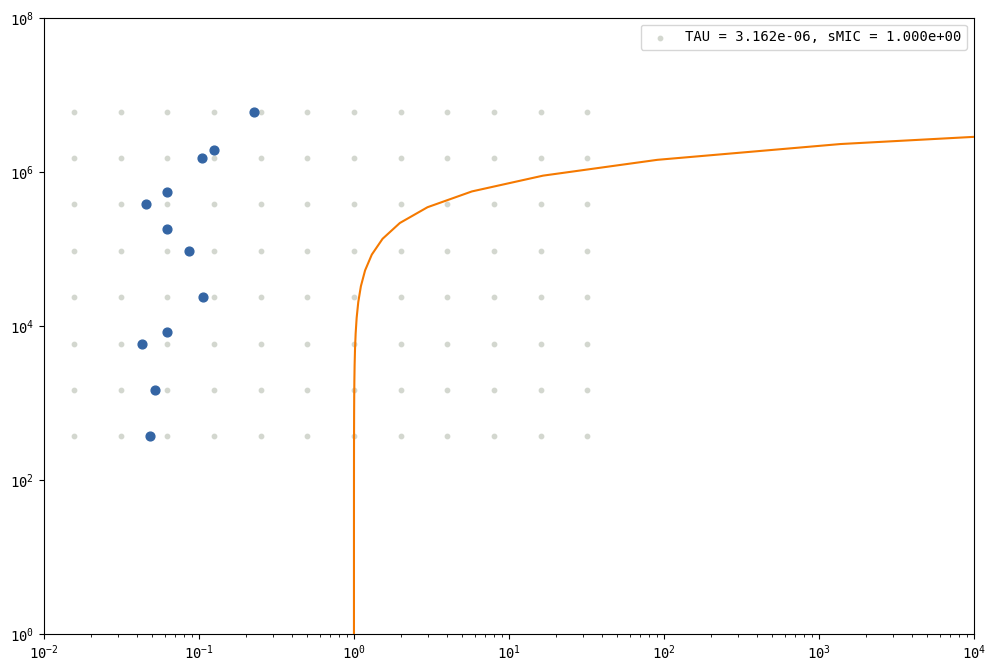

In [6]:
# add buttons for storing, reseting and saving parameters
b_store = widgets.Button(description = 'Store Parameters')
b_reset = widgets.Button(description = 'Reset Parameters')
b_save  = widgets.Button(description = 'Save Parameters')


@interact
def ManualFit(Experiment = data.titles, Transitions = ['standard','GPR'], ShowInocula = True, IdenticalRanges = True, ShowAllTransitions = False,Tau_Exponent = (-8.,-3.), sMIC_Exponent = (-3.,3.), xi = (0.0,2.0,.1)):

    # button on-click functions
    def click_store(b):
        stored_parameters.append(np.array([sMIC_Exponent,Tau_Exponent],dtype = np.float))
    def click_reset(b):
        stored_parameters.clear()
    def click_save(b):
        np.save(outputfile_params,np.vstack(stored_parameters))

    b_store.on_click(click_store)
    b_reset.on_click(click_reset)
    b_save. on_click(click_save )

    tr          = MakeTransitions(Experiment,Transitions,ShowAllTransitions)

    platedesign = data.get_design(dataID = idx)
    xra,yra     = SetScales(IdenticalRanges,ShowInocula,platedesign)
        
    npoints     = np.exp(np.linspace(np.log(yra[0]), np.log(yra[-1]), num = FitPoints))
    
    for m,t in stored_parameters:
        bpoints = 10 ** (m) * np.exp(np.power(10 ** (t) * (npoints - 1), 1./xi))
        plt.plot(bpoints,npoints, c= '#ef2929', zorder = 150)
    
    bpoints = 10 ** (sMIC_Exponent) * np.exp(np.power(10 ** (Tau_Exponent) * (npoints - 1), 1./xi))
    plt.plot(bpoints, npoints, c = '#f57900', zorder = 200)
    
    for title in tr.keys():
        c = '#babdb6'
        zorder = 20
        if title == Experiment:
            c = '#3465a4'
            zorder = 100
        plt.scatter(tr[title][:,0], tr[title][:,1], s = 40, c = c,zorder = zorder)

    plt.legend(['TAU = {:.3e}, sMIC = {:.3e}'.format(10**Tau_Exponent, 10**sMIC_Exponent)])

    
# display buttons at end, not to redraw it every time a slider is moved (which is slow!)
display(b_store,b_reset,b_save)
